source: [Tweedie Loss Function](https://sathesant.medium.com/tweedie-loss-function-395d96883f0b)
```python
xg_reg = xgb.XGBRegressor(objective ='reg:tweedie',
                          tweedie_variance_power=1.5,
                          colsample_bytree = 0.3,
                          learning_rate = 0.1,
                          max_depth = 5, alpha = 10,
                          n_estimators = 10)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
```

Stack Exchange: [Tweedie Loss](https://stats.stackexchange.com/a/492738/368242) for XGBoost

In [1]:
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
from datetime import datetime as dt

import xgboost as xgb
from xgboost import XGBRegressor

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Python
atm_df = pd.read_csv('../data/raw/atm_df.csv')
atm_df.head()

,atm_withdrawals.atm_id,atm_withdrawals.withdrawal_day,atm_withdrawals.load_country,atm_withdrawals.currency,atm_withdrawals.total_amount,atm_withdrawals.total_transactions,atm_details_egypt.atm_id,atm_details_egypt.atm_name,atm_details_egypt.atm_name_arabic,atm_details_egypt.atm_type,atm_details_egypt.atm_group,atm_details_egypt.country,atm_details_egypt.city,atm_details_egypt.atm_location,atm_details_egypt.capacity,atm_details_egypt.cash_limit,atm_details_egypt.currency_notes,atm_details_egypt.atm_location_type,atm_details_egypt.atm_category,atm_details_egypt.atm_model,atm_details_egypt.is_itm,atm_details_egypt.is_recycler,scm_holidays.holiday,scm_holidays.weekday_code,scm_holidays.sequence,scm_holidays.ramadan,scm_holidays.covid_lockdown,scm_holidays.covid_period,scm_holidays.load_country,month,quarter,weekno,month_name,weekday,dayno,year
0,EGA713,04-08-2021,EG,818,53100,31,EGA713,Fathalla Market,فتح الله ماركت,Ncr,Speed,EGYPT,Alexandria,Fathallah Market - Sheraton Montazah Towers - ...,665000,665000,"200,100,50",Market,Offsite,NaN,0,0,NaN,w,www,NaN,NaN,NaN,EG,8,3,31,August,2,4,2021
1,EGA713,05-08-2021,EG,818,93550,42,EGA713,Fathalla Market,فتح الله ماركت,Ncr,Speed,EGYPT,Alexandria,Fathallah Market - Sheraton Montazah Towers - ...,665000,665000,"200,100,50",Market,Offsite,NaN,0,0,NaN,w,wwk,NaN,NaN,NaN,EG,8,3,31,August,3,5,2021
2,EGA713,06-08-2021,EG,818,74950,47,EGA713,Fathalla Market,فتح الله ماركت,Ncr,Speed,EGYPT,Alexandria,Fathallah Market - Sheraton Montazah Towers - ...,665000,665000,"200,100,50",Market,Offsite,NaN,0,0,NaN,k,wkk,NaN,NaN,NaN,EG,8,3,31,August,4,6,2021
3,EGA713,07-08-2021,EG,818,43950,24,EGA713,Fathalla Market,فتح الله ماركت,Ncr,Speed,EGYPT,Alexandria,Fathallah Market - Sheraton Montazah Towers - ...,665000,665000,"200,100,50",Market,Offsite,NaN,0,0,NaN,k,kkw,NaN,NaN,NaN,EG,8,3,31,August,5,7,2021
4,EGA713,08-08-2021,EG,818,59400,33,EGA713,Fathalla Market,فتح الله ماركت,Ncr,Speed,EGYPT,Alexandria,Fathallah Market - Sheraton Montazah Towers - ...,665000,665000,"200,100,50",Market,Offsite,NaN,0,0,NaN,w,kww,NaN,NaN,NaN,EG,8,3,31,August,6,8,2021


In [4]:
print(atm_df.columns)

Index(['atm_withdrawals.atm_id', 'atm_withdrawals.withdrawal_day',
       'atm_withdrawals.load_country', 'atm_withdrawals.currency',
       'atm_withdrawals.total_amount', 'atm_withdrawals.total_transactions',
       'atm_details_egypt.atm_id', 'atm_details_egypt.atm_name',
       'atm_details_egypt.atm_name_arabic', 'atm_details_egypt.atm_type',
       'atm_details_egypt.atm_group', 'atm_details_egypt.country',
       'atm_details_egypt.city', 'atm_details_egypt.atm_location',
       'atm_details_egypt.capacity', 'atm_details_egypt.cash_limit',
       'atm_details_egypt.currency_notes',
       'atm_details_egypt.atm_location_type', 'atm_details_egypt.atm_category',
       'atm_details_egypt.atm_model', 'atm_details_egypt.is_itm',
       'atm_details_egypt.is_recycler', 'scm_holidays.holiday',
       'scm_holidays.weekday_code', 'scm_holidays.sequence',
       'scm_holidays.ramadan', 'scm_holidays.covid_lockdown',
       'scm_holidays.covid_period', 'scm_holidays.load_country', 'month

In [5]:
# Feature Selection
feature_list = ['atm_withdrawals.atm_id', 'atm_withdrawals.total_amount', 'atm_details_egypt.atm_category'
                ,'atm_details_egypt.atm_location_type', 'atm_details_egypt.cash_limit','atm_details_egypt.capacity'
                , 'atm_withdrawals.withdrawal_day'
                ,'dayno','atm_details_egypt.city',  'weekday', 'scm_holidays.weekday_code','atm_details_egypt.atm_group'
                ,'scm_holidays.ramadan', 'atm_details_egypt.is_itm','atm_details_egypt.atm_type','scm_holidays.holiday'
                ,'weekno', 'atm_details_egypt.is_recycler','year','quarter', 'month']

In [6]:
atm_df_fs = atm_df[feature_list]
atm_df_fs.shape

(96817, 21)

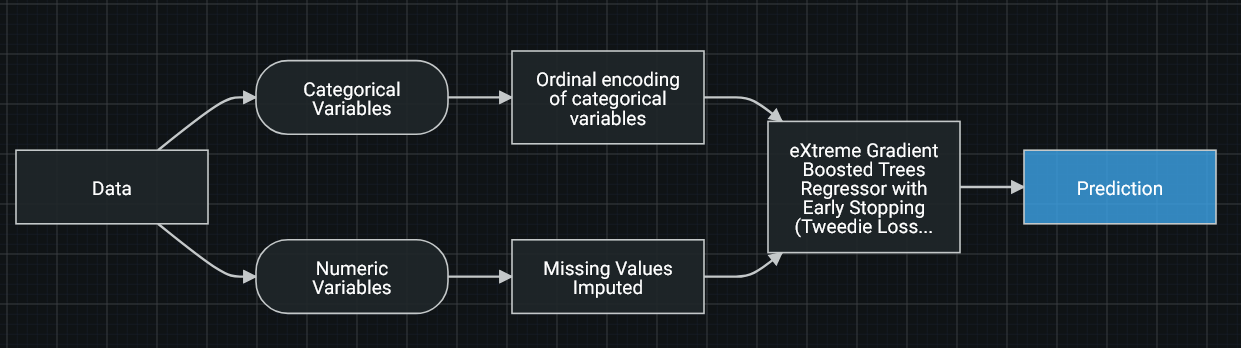

In [161]:
numeric_df = atm_df_fs.select_dtypes(include="int")
numeric_df = pd.concat([numeric_df, atm_df_fs['atm_withdrawals.withdrawal_day']], axis=1)
print(f"Numeric:     {numeric_df.shape}")

categorical_df = atm_df_fs.select_dtypes(exclude="int")
categorical_df.drop(columns=['atm_withdrawals.withdrawal_day'],inplace=True)
print(f"Categorical: {categorical_df.shape}")

Numeric:     (96817, 12)
Categorical: (96817, 9)


In [162]:
numeric_df['atm_withdrawals.total_amount'] = np.where(numeric_df['atm_withdrawals.total_amount'] > numeric_df['atm_details_egypt.capacity']
                                                      , np.median(numeric_df['atm_withdrawals.total_amount'])
                                                      , numeric_df['atm_withdrawals.total_amount'])

In [163]:
categorical_df["scm_holidays.holiday"].fillna(0, inplace=True)
categorical_df["scm_holidays.holiday"] = np.where(categorical_df["scm_holidays.holiday"]!=0, 1, categorical_df["scm_holidays.holiday"])

categorical_df["scm_holidays.ramadan"].fillna(0, inplace=True)
categorical_df["scm_holidays.ramadan"] = np.where(categorical_df["scm_holidays.ramadan"]!=0, 1, categorical_df["scm_holidays.ramadan"])

categorical_df.nunique()

atm_withdrawals.atm_id                 143
atm_details_egypt.atm_category           4
atm_details_egypt.atm_location_type     15
atm_details_egypt.city                  13
scm_holidays.weekday_code                3
atm_details_egypt.atm_group              2
scm_holidays.ramadan                     2
atm_details_egypt.atm_type               3
scm_holidays.holiday                     2
dtype: int64

In [164]:
cols_to_encode = list(categorical_df.columns)

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
# Fit and transform the columns and create a new DataFrame with the new one-hot encoded columns
one_hot_encoded = encoder.fit_transform(categorical_df[cols_to_encode])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(cols_to_encode))

In [165]:
merged_atm_df = pd.concat([numeric_df, categorical_df, one_hot_df], axis=1)
merged_atm_df.head()

,atm_withdrawals.total_amount,atm_details_egypt.cash_limit,atm_details_egypt.capacity,dayno,weekday,atm_details_egypt.is_itm,weekno,atm_details_egypt.is_recycler,year,quarter,month,atm_withdrawals.withdrawal_day,atm_withdrawals.atm_id,atm_details_egypt.atm_category,atm_details_egypt.atm_location_type,atm_details_egypt.city,scm_holidays.weekday_code,atm_details_egypt.atm_group,scm_holidays.ramadan,atm_details_egypt.atm_type,scm_holidays.holiday,atm_withdrawals.atm_id_EGA701,atm_withdrawals.atm_id_EGA702,atm_withdrawals.atm_id_EGA703,atm_withdrawals.atm_id_EGA704,atm_withdrawals.atm_id_EGA705,atm_withdrawals.atm_id_EGA706,atm_withdrawals.atm_id_EGA707,atm_withdrawals.atm_id_EGA708,atm_withdrawals.atm_id_EGA709,atm_withdrawals.atm_id_EGA710,atm_withdrawals.atm_id_EGA711,atm_withdrawals.atm_id_EGA712,atm_withdrawals.atm_id_EGA713,atm_withdrawals.atm_id_EGA714,atm_withdrawals.atm_id_EGA715,atm_withdrawals.atm_id_EGA718,atm_withdrawals.atm_id_EGA719,atm_withdrawals.atm_id_EGA720,atm_withdrawals.atm_id_EGA721,atm_withdrawals.atm_id_EGA722,atm_withdrawals.atm_id_EGA723,atm_withdrawals.atm_id_EGA724,atm_withdrawals.atm_id_EGA726,atm_withdrawals.atm_id_EGA727,atm_withdrawals.atm_id_EGA728,atm_withdrawals.atm_id_EGA729,atm_withdrawals.atm_id_EGA731,atm_withdrawals.atm_id_EGA732,atm_withdrawals.atm_id_EGA733,atm_withdrawals.atm_id_EGA735,atm_withdrawals.atm_id_EGA737,atm_withdrawals.atm_id_EGA739,atm_withdrawals.atm_id_EGA740,atm_withdrawals.atm_id_EGA741,atm_withdrawals.atm_id_EGA743,atm_withdrawals.atm_id_EGA744,atm_withdrawals.atm_id_EGA745,atm_withdrawals.atm_id_EGA746,atm_withdrawals.atm_id_EGA748,atm_withdrawals.atm_id_EGA749,atm_withdrawals.atm_id_EGA750,atm_withdrawals.atm_id_EGA751,atm_withdrawals.atm_id_EGA752,atm_withdrawals.atm_id_EGA753,atm_withdrawals.atm_id_EGA754,atm_withdrawals.atm_id_EGA755,atm_withdrawals.atm_id_EGA756,atm_withdrawals.atm_id_EGA757,atm_withdrawals.atm_id_EGA758,atm_withdrawals.atm_id_EGA759,atm_withdrawals.atm_id_EGA760,atm_withdrawals.atm_id_EGA761,atm_withdrawals.atm_id_EGA762,atm_withdrawals.atm_id_EGA763,atm_withdrawals.atm_id_EGA764,atm_withdrawals.atm_id_EGA765,atm_withdrawals.atm_id_EGA766,atm_withdrawals.atm_id_EGA767,atm_withdrawals.atm_id_EGA768,atm_withdrawals.atm_id_EGA769,atm_withdrawals.atm_id_EGA770,atm_withdrawals.atm_id_EGA771,atm_withdrawals.atm_id_EGA773,atm_withdrawals.atm_id_EGA774,atm_withdrawals.atm_id_EGA775,atm_withdrawals.atm_id_EGA776,atm_withdrawals.atm_id_EGA778,atm_withdrawals.atm_id_EGA780,atm_withdrawals.atm_id_EGA781,atm_withdrawals.atm_id_EGA782,atm_withdrawals.atm_id_EGA783,atm_withdrawals.atm_id_EGA784,atm_withdrawals.atm_id_EGA785,atm_withdrawals.atm_id_EGA786,atm_withdrawals.atm_id_EGA787,atm_withdrawals.atm_id_EGA788,atm_withdrawals.atm_id_EGA789,atm_withdrawals.atm_id_EGA790,atm_withdrawals.atm_id_EGA791,atm_withdrawals.atm_id_EGA792,atm_withdrawals.atm_id_EGA793,atm_withdrawals.atm_id_EGA794,atm_withdrawals.atm_id_EGA795,atm_withdrawals.atm_id_EGA798,atm_withdrawals.atm_id_EGA799,atm_withdrawals.atm_id_EGA801,atm_withdrawals.atm_id_EGA802,atm_withdrawals.atm_id_EGA804,atm_withdrawals.atm_id_EGA805,atm_withdrawals.atm_id_EGA806,atm_withdrawals.atm_id_EGA808,atm_withdrawals.atm_id_EGA810,atm_withdrawals.atm_id_EGA811,atm_withdrawals.atm_id_EGA813,atm_withdrawals.atm_id_EGA816,atm_withdrawals.atm_id_EGA817,atm_withdrawals.atm_id_EGA818,atm_withdrawals.atm_id_EGA820,atm_withdrawals.atm_id_EGA821,atm_withdrawals.atm_id_EGA824,atm_withdrawals.atm_id_EGA826,atm_withdrawals.atm_id_EGA827,atm_withdrawals.atm_id_EGA828,atm_withdrawals.atm_id_EGA829,atm_withdrawals.atm_id_EGA830,atm_withdrawals.atm_id_EGA831,atm_withdrawals.atm_id_EGA833,atm_withdrawals.atm_id_EGA834,atm_withdrawals.atm_id_EGA839,atm_withdrawals.atm_id_EGA840,atm_withdrawals.atm_id_EGA843,atm_withdrawals.atm_id_EGA845,atm_withdrawals.atm_id_EGA846,atm_withdrawals.atm_id_EGA847,atm_withdrawals.atm_id_EGA848,atm_withdrawals.atm_id_EGA849,atm_withdrawals.atm_id_EGA850,atm_withdrawals.atm_id_EGA851,atm_withdraw

In [166]:
merged_atm_df['atm_withdrawals.withdrawal_day'] = pd.to_datetime(merged_atm_df['atm_withdrawals.withdrawal_day'], format="%d-%m-%Y")

In [167]:
cutoff_date = merged_atm_df['atm_withdrawals.withdrawal_day'].max() - pd.DateOffset(months=4)

# Create train and test DataFrames based on the cutoff date
train_df = merged_atm_df[merged_atm_df['atm_withdrawals.withdrawal_day'] <= cutoff_date]
test_df = merged_atm_df[merged_atm_df['atm_withdrawals.withdrawal_day'] > cutoff_date]

print("Training DataFrame:")
display(train_df.tail())

print("\nTest DataFrame:")
display(test_df.tail())

Training DataFrame:


,atm_withdrawals.total_amount,atm_details_egypt.cash_limit,atm_details_egypt.capacity,dayno,weekday,atm_details_egypt.is_itm,weekno,atm_details_egypt.is_recycler,year,quarter,month,atm_withdrawals.withdrawal_day,atm_withdrawals.atm_id,atm_details_egypt.atm_category,atm_details_egypt.atm_location_type,atm_details_egypt.city,scm_holidays.weekday_code,atm_details_egypt.atm_group,scm_holidays.ramadan,atm_details_egypt.atm_type,scm_holidays.holiday,atm_withdrawals.atm_id_EGA701,atm_withdrawals.atm_id_EGA702,atm_withdrawals.atm_id_EGA703,atm_withdrawals.atm_id_EGA704,atm_withdrawals.atm_id_EGA705,atm_withdrawals.atm_id_EGA706,atm_withdrawals.atm_id_EGA707,atm_withdrawals.atm_id_EGA708,atm_withdrawals.atm_id_EGA709,atm_withdrawals.atm_id_EGA710,atm_withdrawals.atm_id_EGA711,atm_withdrawals.atm_id_EGA712,atm_withdrawals.atm_id_EGA713,atm_withdrawals.atm_id_EGA714,atm_withdrawals.atm_id_EGA715,atm_withdrawals.atm_id_EGA718,atm_withdrawals.atm_id_EGA719,atm_withdrawals.atm_id_EGA720,atm_withdrawals.atm_id_EGA721,atm_withdrawals.atm_id_EGA722,atm_withdrawals.atm_id_EGA723,atm_withdrawals.atm_id_EGA724,atm_withdrawals.atm_id_EGA726,atm_withdrawals.atm_id_EGA727,atm_withdrawals.atm_id_EGA728,atm_withdrawals.atm_id_EGA729,atm_withdrawals.atm_id_EGA731,atm_withdrawals.atm_id_EGA732,atm_withdrawals.atm_id_EGA733,atm_withdrawals.atm_id_EGA735,atm_withdrawals.atm_id_EGA737,atm_withdrawals.atm_id_EGA739,atm_withdrawals.atm_id_EGA740,atm_withdrawals.atm_id_EGA741,atm_withdrawals.atm_id_EGA743,atm_withdrawals.atm_id_EGA744,atm_withdrawals.atm_id_EGA745,atm_withdrawals.atm_id_EGA746,atm_withdrawals.atm_id_EGA748,atm_withdrawals.atm_id_EGA749,atm_withdrawals.atm_id_EGA750,atm_withdrawals.atm_id_EGA751,atm_withdrawals.atm_id_EGA752,atm_withdrawals.atm_id_EGA753,atm_withdrawals.atm_id_EGA754,atm_withdrawals.atm_id_EGA755,atm_withdrawals.atm_id_EGA756,atm_withdrawals.atm_id_EGA757,atm_withdrawals.atm_id_EGA758,atm_withdrawals.atm_id_EGA759,atm_withdrawals.atm_id_EGA760,atm_withdrawals.atm_id_EGA761,atm_withdrawals.atm_id_EGA762,atm_withdrawals.atm_id_EGA763,atm_withdrawals.atm_id_EGA764,atm_withdrawals.atm_id_EGA765,atm_withdrawals.atm_id_EGA766,atm_withdrawals.atm_id_EGA767,atm_withdrawals.atm_id_EGA768,atm_withdrawals.atm_id_EGA769,atm_withdrawals.atm_id_EGA770,atm_withdrawals.atm_id_EGA771,atm_withdrawals.atm_id_EGA773,atm_withdrawals.atm_id_EGA774,atm_withdrawals.atm_id_EGA775,atm_withdrawals.atm_id_EGA776,atm_withdrawals.atm_id_EGA778,atm_withdrawals.atm_id_EGA780,atm_withdrawals.atm_id_EGA781,atm_withdrawals.atm_id_EGA782,atm_withdrawals.atm_id_EGA783,atm_withdrawals.atm_id_EGA784,atm_withdrawals.atm_id_EGA785,atm_withdrawals.atm_id_EGA786,atm_withdrawals.atm_id_EGA787,atm_withdrawals.atm_id_EGA788,atm_withdrawals.atm_id_EGA789,atm_withdrawals.atm_id_EGA790,atm_withdrawals.atm_id_EGA791,atm_withdrawals.atm_id_EGA792,atm_withdrawals.atm_id_EGA793,atm_withdrawals.atm_id_EGA794,atm_withdrawals.atm_id_EGA795,atm_withdrawals.atm_id_EGA798,atm_withdrawals.atm_id_EGA799,atm_withdrawals.atm_id_EGA801,atm_withdrawals.atm_id_EGA802,atm_withdrawals.atm_id_EGA804,atm_withdrawals.atm_id_EGA805,atm_withdrawals.atm_id_EGA806,atm_withdrawals.atm_id_EGA808,atm_withdrawals.atm_id_EGA810,atm_withdrawals.atm_id_EGA811,atm_withdrawals.atm_id_EGA813,atm_withdrawals.atm_id_EGA816,atm_withdrawals.atm_id_EGA817,atm_withdrawals.atm_id_EGA818,atm_withdrawals.atm_id_EGA820,atm_withdrawals.atm_id_EGA821,atm_withdrawals.atm_id_EGA824,atm_withdrawals.atm_id_EGA826,atm_withdrawals.atm_id_EGA827,atm_withdrawals.atm_id_EGA828,atm_withdrawals.atm_id_EGA829,atm_withdrawals.atm_id_EGA830,atm_withdrawals.atm_id_EGA831,atm_withdrawals.atm_id_EGA833,atm_withdrawals.atm_id_EGA834,atm_withdrawals.atm_id_EGA839,atm_withdrawals.atm_id_EGA840,atm_withdrawals.atm_id_EGA843,atm_withdrawals.atm_id_EGA845,atm_withdrawals.atm_id_EGA846,atm_withdrawals.atm_id_EGA847,atm_withdrawals.atm_id_EGA848,atm_withdrawals.atm_id_EGA849,atm_withdrawals.atm_id_EGA850,atm_withdrawals.atm_id_EGA851,atm_withdraw


Test DataFrame:


,atm_withdrawals.total_amount,atm_details_egypt.cash_limit,atm_details_egypt.capacity,dayno,weekday,atm_details_egypt.is_itm,weekno,atm_details_egypt.is_recycler,year,quarter,month,atm_withdrawals.withdrawal_day,atm_withdrawals.atm_id,atm_details_egypt.atm_category,atm_details_egypt.atm_location_type,atm_details_egypt.city,scm_holidays.weekday_code,atm_details_egypt.atm_group,scm_holidays.ramadan,atm_details_egypt.atm_type,scm_holidays.holiday,atm_withdrawals.atm_id_EGA701,atm_withdrawals.atm_id_EGA702,atm_withdrawals.atm_id_EGA703,atm_withdrawals.atm_id_EGA704,atm_withdrawals.atm_id_EGA705,atm_withdrawals.atm_id_EGA706,atm_withdrawals.atm_id_EGA707,atm_withdrawals.atm_id_EGA708,atm_withdrawals.atm_id_EGA709,atm_withdrawals.atm_id_EGA710,atm_withdrawals.atm_id_EGA711,atm_withdrawals.atm_id_EGA712,atm_withdrawals.atm_id_EGA713,atm_withdrawals.atm_id_EGA714,atm_withdrawals.atm_id_EGA715,atm_withdrawals.atm_id_EGA718,atm_withdrawals.atm_id_EGA719,atm_withdrawals.atm_id_EGA720,atm_withdrawals.atm_id_EGA721,atm_withdrawals.atm_id_EGA722,atm_withdrawals.atm_id_EGA723,atm_withdrawals.atm_id_EGA724,atm_withdrawals.atm_id_EGA726,atm_withdrawals.atm_id_EGA727,atm_withdrawals.atm_id_EGA728,atm_withdrawals.atm_id_EGA729,atm_withdrawals.atm_id_EGA731,atm_withdrawals.atm_id_EGA732,atm_withdrawals.atm_id_EGA733,atm_withdrawals.atm_id_EGA735,atm_withdrawals.atm_id_EGA737,atm_withdrawals.atm_id_EGA739,atm_withdrawals.atm_id_EGA740,atm_withdrawals.atm_id_EGA741,atm_withdrawals.atm_id_EGA743,atm_withdrawals.atm_id_EGA744,atm_withdrawals.atm_id_EGA745,atm_withdrawals.atm_id_EGA746,atm_withdrawals.atm_id_EGA748,atm_withdrawals.atm_id_EGA749,atm_withdrawals.atm_id_EGA750,atm_withdrawals.atm_id_EGA751,atm_withdrawals.atm_id_EGA752,atm_withdrawals.atm_id_EGA753,atm_withdrawals.atm_id_EGA754,atm_withdrawals.atm_id_EGA755,atm_withdrawals.atm_id_EGA756,atm_withdrawals.atm_id_EGA757,atm_withdrawals.atm_id_EGA758,atm_withdrawals.atm_id_EGA759,atm_withdrawals.atm_id_EGA760,atm_withdrawals.atm_id_EGA761,atm_withdrawals.atm_id_EGA762,atm_withdrawals.atm_id_EGA763,atm_withdrawals.atm_id_EGA764,atm_withdrawals.atm_id_EGA765,atm_withdrawals.atm_id_EGA766,atm_withdrawals.atm_id_EGA767,atm_withdrawals.atm_id_EGA768,atm_withdrawals.atm_id_EGA769,atm_withdrawals.atm_id_EGA770,atm_withdrawals.atm_id_EGA771,atm_withdrawals.atm_id_EGA773,atm_withdrawals.atm_id_EGA774,atm_withdrawals.atm_id_EGA775,atm_withdrawals.atm_id_EGA776,atm_withdrawals.atm_id_EGA778,atm_withdrawals.atm_id_EGA780,atm_withdrawals.atm_id_EGA781,atm_withdrawals.atm_id_EGA782,atm_withdrawals.atm_id_EGA783,atm_withdrawals.atm_id_EGA784,atm_withdrawals.atm_id_EGA785,atm_withdrawals.atm_id_EGA786,atm_withdrawals.atm_id_EGA787,atm_withdrawals.atm_id_EGA788,atm_withdrawals.atm_id_EGA789,atm_withdrawals.atm_id_EGA790,atm_withdrawals.atm_id_EGA791,atm_withdrawals.atm_id_EGA792,atm_withdrawals.atm_id_EGA793,atm_withdrawals.atm_id_EGA794,atm_withdrawals.atm_id_EGA795,atm_withdrawals.atm_id_EGA798,atm_withdrawals.atm_id_EGA799,atm_withdrawals.atm_id_EGA801,atm_withdrawals.atm_id_EGA802,atm_withdrawals.atm_id_EGA804,atm_withdrawals.atm_id_EGA805,atm_withdrawals.atm_id_EGA806,atm_withdrawals.atm_id_EGA808,atm_withdrawals.atm_id_EGA810,atm_withdrawals.atm_id_EGA811,atm_withdrawals.atm_id_EGA813,atm_withdrawals.atm_id_EGA816,atm_withdrawals.atm_id_EGA817,atm_withdrawals.atm_id_EGA818,atm_withdrawals.atm_id_EGA820,atm_withdrawals.atm_id_EGA821,atm_withdrawals.atm_id_EGA824,atm_withdrawals.atm_id_EGA826,atm_withdrawals.atm_id_EGA827,atm_withdrawals.atm_id_EGA828,atm_withdrawals.atm_id_EGA829,atm_withdrawals.atm_id_EGA830,atm_withdrawals.atm_id_EGA831,atm_withdrawals.atm_id_EGA833,atm_withdrawals.atm_id_EGA834,atm_withdrawals.atm_id_EGA839,atm_withdrawals.atm_id_EGA840,atm_withdrawals.atm_id_EGA843,atm_withdrawals.atm_id_EGA845,atm_withdrawals.atm_id_EGA846,atm_withdrawals.atm_id_EGA847,atm_withdrawals.atm_id_EGA848,atm_withdrawals.atm_id_EGA849,atm_withdrawals.atm_id_EGA850,atm_withdrawals.atm_id_EGA851,atm_withdraw

In [168]:
X_train = train_df.drop(columns=['atm_withdrawals.withdrawal_day', 'atm_withdrawals.total_amount'])
X_test = test_df.drop(columns=['atm_withdrawals.withdrawal_day', 'atm_withdrawals.total_amount'])

# Use the 'amount' column as the label (y)
y_train = train_df['atm_withdrawals.total_amount']
y_test = test_df['atm_withdrawals.total_amount']

print(f"X_train: {X_train.shape} & X_test: {X_test.shape}")
print(f"y_train: {y_train.shape} & y_test: {y_test.shape}")

X_train: (79551, 206) & X_test: (17266, 206)
y_train: (79551,) & y_test: (17266,)


# XGBoost

In [169]:
start = dt.now()
print(start)

# Cutoff date is the value which is the split point for Train-Test datasets
cutoff_date = merged_atm_df['atm_withdrawals.withdrawal_day'].max() - pd.DateOffset(months=4)

# Drop categorical columns from training_df as it has been OneHotEncoded already
merged_atm_df.drop(cols_to_encode, axis=1, inplace=True)


# Create train and test DataFrames based on the cutoff date
train_df = merged_atm_df[merged_atm_df['atm_withdrawals.withdrawal_day'] <= cutoff_date]
test_df = merged_atm_df[merged_atm_df['atm_withdrawals.withdrawal_day'] > cutoff_date]
X_train = train_df.drop(columns=['atm_withdrawals.withdrawal_day', 'atm_withdrawals.total_amount'])
X_test = test_df.drop(columns=['atm_withdrawals.withdrawal_day', 'atm_withdrawals.total_amount'])
y_train = train_df['atm_withdrawals.total_amount']
y_test = test_df['atm_withdrawals.total_amount']

# Initialize XGBRegressor with supported parameters
xgb_model = XGBRegressor(
    objective='reg:tweedie',
    booster='gbtree',
    learning_rate=0.05,
    n_estimators=2500,
    scale_pos_weight=1.0,
    max_delta_step=0.0,
    tweedie_variance_power=1.5,  # Corresponds to tweedie_p
    missing=0.0,  # Set missing values to 0.0
    base_score=0.5,  # Default value, for base_margin_initialize
    random_state=1234,
    subsample=1.0,
    max_depth=3,  # You've listed multiple values, you may want to grid search this
    min_child_weight=1.0,
    colsample_bytree=0.3,
    colsample_bylevel=1.0,
    gamma=0.01,  # Corresponds to min_split_loss
    num_parallel_tree=1,
    tree_method='auto',
    max_bin=256,
    reg_lambda=1.0,
    reg_alpha=0.0
)

# Fit the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

end = dt.now()
print(end)
print(end-start)

# Calculate the MAE
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
res_xgb = ('{:,}'.format(round(mae_xgb)))
print(f"Mean Absolute Error: {res_xgb}")

2023-10-10 16:28:36.080626
2023-10-10 16:28:44.785100
0:00:08.704474
Mean Absolute Error: 56,170


# TSP on the model error

In [225]:
# Cutoff date is the value which is the split point for Train-Test datasets
cutoff_date = pd.to_datetime(atm_df_fs['atm_withdrawals.withdrawal_day'], format = "%d-%m-%Y").max() - pd.DateOffset(months=4)

atm_id = atm_df_fs[pd.to_datetime(atm_df_fs['atm_withdrawals.withdrawal_day'], format = "%d-%m-%Y") > cutoff_date]['atm_withdrawals.atm_id'].values
day = atm_df_fs[pd.to_datetime(atm_df_fs['atm_withdrawals.withdrawal_day'], format = "%d-%m-%Y") > cutoff_date]['atm_withdrawals.withdrawal_day'].values
mae_xgb_df = pd.DataFrame({
    'date': day
    ,'atm_id': atm_id
    ,'actuals': y_test
    ,'preds': y_pred_xgb
    ,'diff': y_test - y_pred_xgb
})

mae_xgb_df['date'] = pd.to_datetime(mae_xgb_df['date'], format="%d-%m-%Y")
mae_xgb_df['week_number'] = mae_xgb_df['date'].dt.isocalendar().week

mae_xgb_df_grouped = mae_xgb_df.groupby(by=['week_number'],as_index=False).agg({
    'actuals':['sum','mean']
    , 'preds':['sum','mean']
    , 'diff':['sum','mean']
})
# Reset column names and flatten MultiIndex
mae_xgb_df_grouped.columns = ['_'.join(col).strip() for col in mae_xgb_df_grouped.columns.values]
# Reset index for better readability
mae_xgb_df_grouped.reset_index(inplace=True, drop=True)

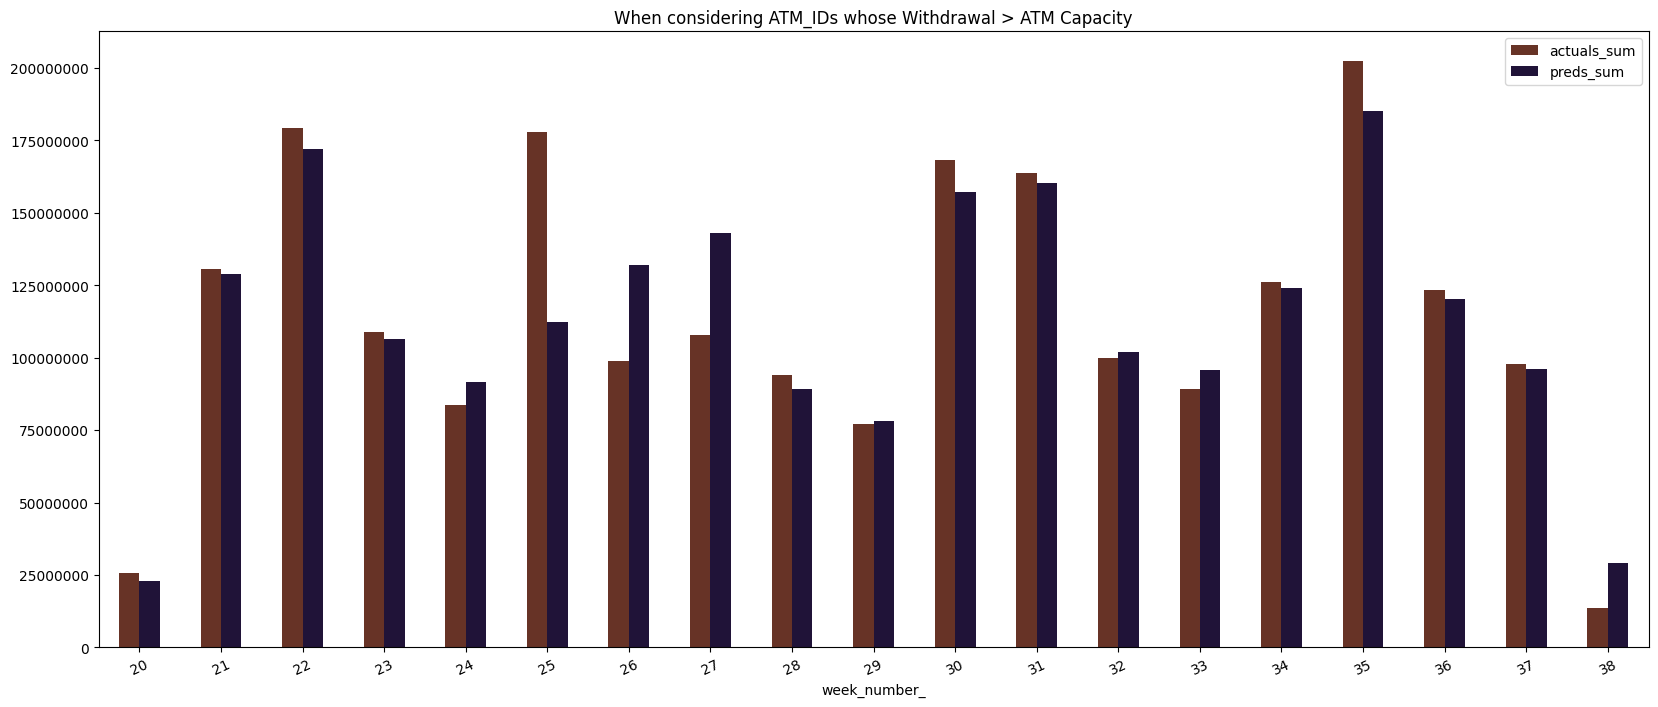

In [240]:
from matplotlib import pyplot as plt
ax = mae_xgb_df_grouped.plot(x="week_number_", y=["actuals_sum", "preds_sum"], kind="bar", rot=25, color=["#673326","#201338"],figsize=(20, 8))
plt.title('When considering ATM_IDs whose Withdrawal > ATM Capacity')
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)

In [214]:
mae_xgb_df_grouped

,week_number_,actuals_sum,actuals_mean,preds_sum,preds_mean,diff_sum,diff_mean
0,20,25681860.0,94418.602941,22995770.0,84543.273438,2.686090e+06,9875.331687
1,21,130680035.0,137268.944328,128733528.0,135224.296875,1.946505e+06,2044.647963
2,22,179296860.0,187157.473904,171886736.0,179422.484375,7.410130e+06,7735.000458
3,23,108829850.0,113128.742204,106578432.0,110788.390625,2.251416e+06,2340.348950
4,24,83549235.0,86489.891304,91491736.0,94711.945312,-7.942505e+06,-8222.054378
5,25,177944355.0,184207.406832,112270536.0,116222.085938,6.567382e+07,67985.316596
6,26,98690165.0,101428.741007,132065352.0,135730.062500,-3.337519e+07,-34301.324990
7,27,107889970.0,110091.806122,143171248.0,146093.109375,-3.528127e+07,-36001.297745
8,28,93975425.0,95893.290816,89211696.0,91032.343750,4.763728e+06,4860.947331
9,29,77243180.0,78419.472081,78083048.0,79272.132812,-8.398649e+05,-852.654771


In [35]:
atm_id = atm_df_fs[pd.to_datetime(atm_df_fs['atm_withdrawals.withdrawal_day'], format = "%d-%m-%Y") > cutoff_date]['atm_withdrawals.atm_id'].values
day = atm_df_fs[pd.to_datetime(atm_df_fs['atm_withdrawals.withdrawal_day'], format = "%d-%m-%Y") > cutoff_date]['atm_withdrawals.withdrawal_day'].values
pred_error_df = pd.DataFrame({
    'ds': day
    , 'atm_id': atm_id
    , 'y': y_test - y_pred_xgb
})

pred_error_df['ds'] = pd.to_datetime(pred_error_df['ds'], format="%d-%m-%Y")

pred_error_df

,ds,atm_id,y
654,2023-05-20,EGA713,-24494.062500
655,2023-05-21,EGA713,-5560.273438
656,2023-05-22,EGA713,-26350.562500
657,2023-05-23,EGA713,-22258.968750
658,2023-05-24,EGA713,-39665.578125
...,...,...,...
96812,2023-09-15,EGA889,-63609.414062
96813,2023-09-16,EGA889,-58391.523438
96814,2023-09-17,EGA889,-94532.625000
96815,2023-09-18,EGA889,-95212.656250


In [36]:
from prophet import Prophet
import pandas as pd

# Initialize an empty dictionary to store the fitted models for each atm_id
fitted_models = {}

# Loop through each unique atm_id
for atm in pred_error_df['atm_id'].unique():
    # Filter the dataframe to include only rows for this atm_id
    df_filtered = pred_error_df[pred_error_df['atm_id'] == atm]
    
    # Drop the 'atm_id' column, Prophet doesn't need it
    df_prophet = df_filtered.drop('atm_id', axis=1)
    
    # Initialize and fit the model
    model = Prophet()
    model.fit(df_prophet)
    
    # Store the fitted model in the dictionary
    fitted_models[atm] = model

12:40:56 - cmdstanpy - INFO - Chain [1] start processing
12:40:56 - cmdstanpy - INFO - Chain [1] done processing
12:40:57 - cmdstanpy - INFO - Chain [1] start processing
12:40:57 - cmdstanpy - INFO - Chain [1] done processing
12:40:57 - cmdstanpy - INFO - Chain [1] start processing
12:40:57 - cmdstanpy - INFO - Chain [1] done processing
12:40:57 - cmdstanpy - INFO - Chain [1] start processing
12:40:57 - cmdstanpy - INFO - Chain [1] done processing
12:40:57 - cmdstanpy - INFO - Chain [1] start processing
12:40:57 - cmdstanpy - INFO - Chain [1] done processing
12:40:57 - cmdstanpy - INFO - Chain [1] start processing
12:40:57 - cmdstanpy - INFO - Chain [1] done processing
12:40:57 - cmdstanpy - INFO - Chain [1] start processing
12:40:57 - cmdstanpy - INFO - Chain [1] done processing
12:40:57 - cmdstanpy - INFO - Chain [1] start processing
12:40:57 - cmdstanpy - INFO - Chain [1] done processing
12:40:57 - cmdstanpy - INFO - Chain [1] start processing
12:40:58 - cmdstanpy - INFO - Chain [1]

In [37]:
print("ATM IDs for which models have been fitted:\n",fitted_models.keys())

ATM IDs for which models have been fitted:
 dict_keys(['EGA713', 'EGA750', 'EGA762', 'EGA720', 'EGA790', 'EGA827', 'EGA793', 'EGA766', 'EGA760', 'EGA712', 'EGA707', 'EGA808', 'EGA817', 'EGA756', 'EGA759', 'EGA794', 'EGA783', 'EGA824', 'EGA724', 'EGA723', 'EGA702', 'EGA801', 'EGA718', 'EGA701', 'EGA784', 'EGA705', 'EGA764', 'EGA727', 'EGA787', 'EGA818', 'EGA719', 'EGA788', 'EGA744', 'EGA704', 'EGA729', 'EGA770', 'EGA728', 'EGA740', 'EGA810', 'EGA820', 'EGA826', 'EGA816', 'EGA802', 'EGA778', 'EGA774', 'EGA714', 'EGA732', 'EGA765', 'EGA773', 'EGA811', 'EGA792', 'EGA771', 'EGA722', 'EGA739', 'EGA748', 'EGA813', 'EGA806', 'EGA746', 'EGA754', 'EGA752', 'EGA804', 'EGA763', 'EGA741', 'EGA768', 'EGA703', 'EGA761', 'EGA780', 'EGA786', 'EGA789', 'EGA726', 'EGA745', 'EGA721', 'EGA757', 'EGA751', 'EGA733', 'EGA821', 'EGA781', 'EGA828', 'EGA753', 'EGA731', 'EGA798', 'EGA737', 'EGA776', 'EGA833', 'EGA749', 'EGA805', 'EGA710', 'EGA791', 'EGA711', 'EGA775', 'EGA834', 'EGA785', 'EGA830', 'EGA706', 'EGA7

In [38]:
atm_df_fs.groupby(by=['atm_withdrawals.atm_id'])['atm_withdrawals.withdrawal_day'].nunique()

atm_withdrawals.atm_id
EGA701    777
EGA702    777
EGA703    777
EGA704    777
EGA705    777
         ... 
EGA882     83
EGA884     82
EGA886     63
EGA887     46
EGA889     48
Name: atm_withdrawals.withdrawal_day, Length: 143, dtype: int64

In [33]:
some_atm_id = "EGA713"
future_ts = 2

# Initialize an empty DataFrame to store all the predictions
all_predictions = pd.DataFrame()

# Loop through each unique atm_id and its corresponding model
for atm_id, model in fitted_models.items():
    
    # Create a DataFrame with future dates (2 time steps into the future)
    future = model.make_future_dataframe(periods=future_ts)
    
    # Generate forecasts
    forecast = model.predict(future)
    
    # Keep only the last two time steps (the ones we've just predicted)
    forecast = forecast.tail(future_ts)
    
    # Add the atm_id to the forecast DataFrame
    forecast['atm_id'] = atm_id
    
    # Append this forecast to the all_predictions DataFrame
    all_predictions = pd.concat([all_predictions, forecast])

# Now, all_predictions contains the 2-step ahead forecasts for each ATM ID
all_predictions[["ds", 'atm_id', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,atm_id,yhat,yhat_lower,yhat_upper
123,2023-09-20,EGA713,7564.140314,-65676.488596,79867.206575
124,2023-09-21,EGA713,5506.399185,-73140.463351,80277.875203
123,2023-09-20,EGA750,-16159.819271,-254644.718778,230355.689334
124,2023-09-21,EGA750,-27777.612032,-253327.188375,189597.819992
123,2023-09-20,EGA762,-33937.485780,-126261.872778,60419.208439
...,...,...,...,...,...
64,2023-09-21,EGA886,-145909.609969,-194379.450703,-95394.883119
46,2023-09-20,EGA887,-160983.307553,-214839.442350,-95961.876422
47,2023-09-21,EGA887,-170737.820367,-228344.996695,-113796.393725
48,2023-09-20,EGA889,-125993.257147,-175901.298569,-76252.544516


# Random Forest

In [74]:
from sklearn.pipeline import Pipelinefrom sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [ ]:
start = dt.now()
print(start)
param_grid = {
    'model__n_estimators': [150, 300, 500],
    'model__max_depth': [25, 30, 50, 100],
    'model__min_samples_split': [10, 50, 100],
    'model__min_samples_leaf': [1]
}
grid_HGSearch = HalvingGridSearchCV(
    estimator=pipeline,
    param_grid=param_grid, 
    scoring='neg_mean_absolute_error', 
    cv=3, 
    random_state=0).fit(X_train, y_train)

end = dt.now()
print(end)
print(end-start)

In [ ]:
# Get the best parameters and best score (Negative MAE)
grid_HGSearch_best_params = grid_HGSearch.best_params_
grid_HGSearch_best_score = -grid_HGSearch.best_score_

In [101]:
grid_HGSearch_best_params

{'model__max_depth': 30,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 10,
 'model__n_estimators': 150}

In [100]:
start = dt.now()
print(start)
# Define the model with the best parameters
model_optimized = RandomForestRegressor(n_estimators = grid_HGSearch_best_params['model__n_estimators'],
                                        max_depth = grid_HGSearch_best_params['model__max_depth'],
                                        min_samples_split = grid_HGSearch_best_params['model__min_samples_split'],
                                        min_samples_leaf = grid_HGSearch_best_params['model__min_samples_leaf'],
                                        random_state = 42)
model_optimized.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds_selected = model_optimized.predict(X_test)

# Evaluate the model
mae_selected = mean_absolute_error(y_test, preds_selected)

res = ('{:,}'.format(round(mae)))
print(f"Mean Absolute Error: {res}")

end = dt.now()
print(end)
print(end-start)

2023-10-10 11:21:00.129137
Mean Absolute Error: 56,841
2023-10-10 11:22:16.066472
0:01:15.937335
